# **Midterm: Banknote Classification Analysis**  
**Author:** Joanna Farris  
**Date:** November 11, 2025  
**Objective:** Build and evaluate classification models to predict whether a banknote is genuine or forged using the Banknote Authentication Dataset.

## **Introduction**
This project uses the *Banknote Authentication* dataset to build a classification model that can distinguish between **forged** and **authentic** banknotes. Each banknote image was processed using a wavelet transform, and four statistical features were extracted from those transformed images: **variance**, **skewness**, **kurtosis**, and **entropy**. The goal of this analysis is to use these features to train machine learning models that accurately predict whether a banknote is genuine or counterfeit.

In [1]:
# all imports at the top, organized
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

from graphviz import Source
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

## **Section 1. Import and Inspect the Data**

**1.1 Load the dataset and display the first 10 rows**

In [2]:
# Load dataset directly from the UCI URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
columns = ["variance", "skewness", "curtosis", "entropy", "class"]
df = pd.read_csv(url, header=None, names=columns)

# Save a local copy for reproducibility
os.makedirs("data", exist_ok=True)
df.to_csv("data/banknote_authentication.csv", index=False)

# Quick preview
df.head(10)

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.80730,-0.44699,0
1,4.54590,8.1674,-2.45860,-1.46210,0
2,3.86600,-2.6383,1.92420,0.10645,0
3,3.45660,9.5228,-4.01120,-3.59440,0
4,0.32924,-4.4552,4.57180,-0.98880,0
5,4.36840,9.6718,-3.96060,-3.16250,0
6,3.59120,3.0129,0.72888,0.56421,0
7,2.09220,-6.8100,8.46360,-0.60216,0
8,3.20320,5.7588,-0.75345,-0.61251,0
9,1.53560,9.1772,-2.27180,-0.73535,0


**1.2 Check for missing values and display summary statistics**

In [3]:
print("Missing Values per Column:")
print()
print(df.isnull().sum())

print("\nSummary Statistics:")
print()
print(df.describe())

Missing Values per Column:

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

Summary Statistics:

          variance     skewness     curtosis      entropy        class
count  1372.000000  1372.000000  1372.000000  1372.000000  1372.000000
mean      0.433735     1.922353     1.397627    -1.191657     0.444606
std       2.842763     5.869047     4.310030     2.101013     0.497103
min      -7.042100   -13.773100    -5.286100    -8.548200     0.000000
25%      -1.773000    -1.708200    -1.574975    -2.413450     0.000000
50%       0.496180     2.319650     0.616630    -0.586650     0.000000
75%       2.821475     6.814625     3.179250     0.394810     1.000000
max       6.824800    12.951600    17.927400     2.449500     1.000000


**Reflection 1: This is a very clean dataset with no missing values.**

## **Section 2. Data Exploration and Preparation**

**2.1 Explore data patterns and distributions** 

Feature Distributions: Histograms show varied shapes across features.


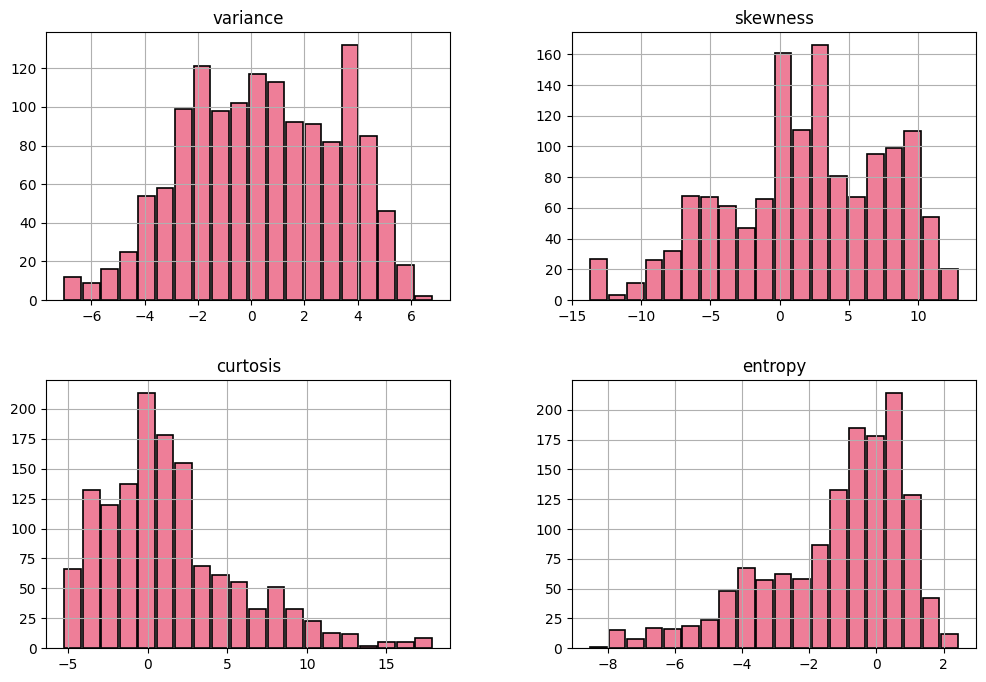

In [4]:
print("Feature Distributions: Histograms show varied shapes across features.")
# Generate histograms for all numerical columns
df.drop(columns=['class']).hist(
    bins=20,
    figsize=(12, 8),
    color="#ee7e98",
    edgecolor='black',
    linewidth=1.2,
    rwidth=0.9    # 1.0 = bars touch, smaller = gaps between
)
plt.show()

- **Variance:** roughly symmetric, maybe slightly left-skewed.  
- **Skewness:** clearly bimodal (two peaks) — interesting pattern.  
- **Curtosis:** right-skewed, with several outliers on the high end.  
- **Entropy:** left-skewed, most values near 0.  

Feature Distributions: Boxplots confirm what the histograms showed.


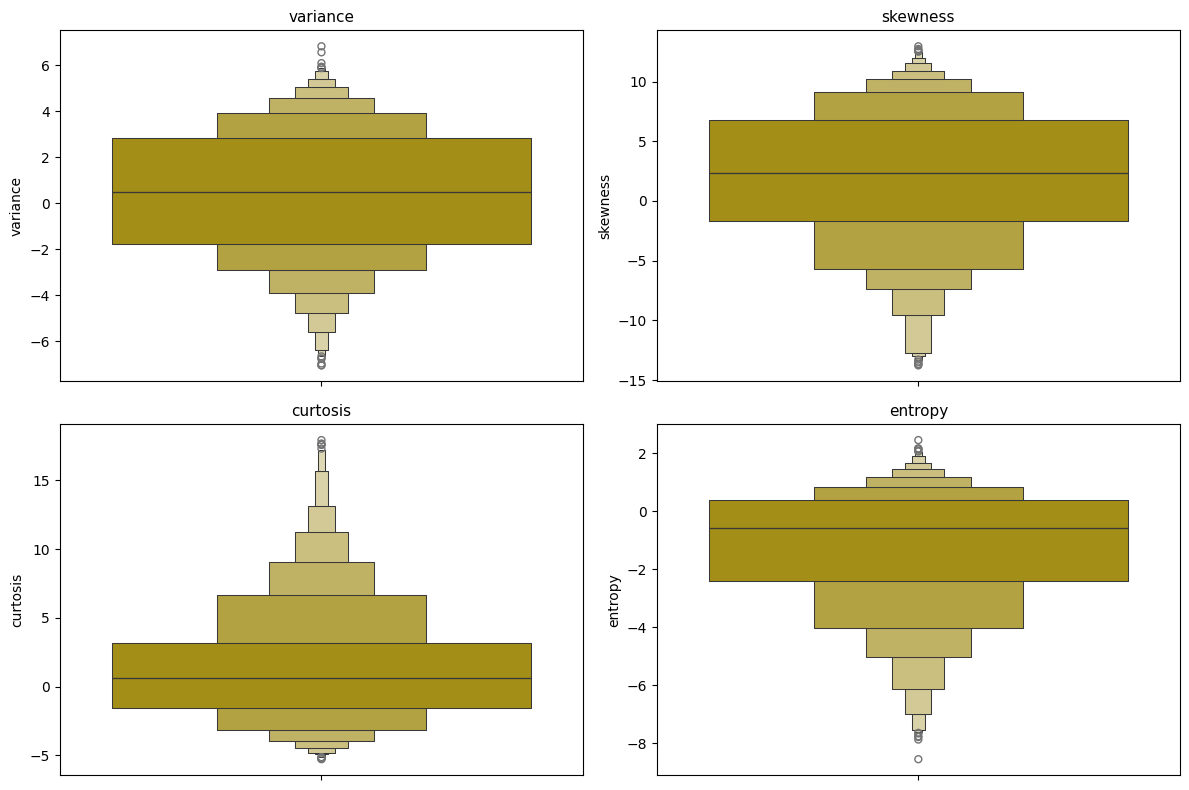

In [13]:
print("Feature Distributions: Boxplots confirm what the histograms showed.")

features = df.columns[:-1]  # exclude 'class'
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, column in zip(axes.flat, features, strict=True):
    sns.boxenplot(data=df, y=column, color="#ba9e00", ax=ax)
    ax.set_title(f'{column}', fontsize=11)

plt.tight_layout()
plt.show()


- **Variance:** nearly symmetric, few outliers at both ends.
- **Skewness:** wider spread, visible outliers at extremes — consistent with its bimodal histogram.
- **Curtosis:** clear right skew with high-end outliers — heavy upper tail.
- **Entropy:** mostly clustered near 0 with lower-end outliers — left skew.  

**Reflection 2:**

The feature distributions show varied shapes across the four predictors. Variance appears roughly symmetric, while skewness is more dispersed and slightly bimodal. Curtosis shows a clear right skew with several high-end outliers, and entropy is left-skewed with a few extreme low values. These differences suggest that each feature captures a distinct characteristic of the images, which should help the model separate classes.  
 
No major preprocessing was required, as the dataset was already clean and numeric. No new features were created or modified. The only adjustments involved excluding the target column from visualizations to maintain symmetry and, if needed, preparing to scale features depending on the model type.

## **Section 3. Feature Selection and Justification**

**3.1 Choose features and target**

- **Features:** variance, skewness, curtosis, entropy 

- **Target:** class (0 = forged, 1 = authentic) 

**Why:** These four inputs are the standard, information-rich summaries of each banknote’s wavelet coefficients (spread, asymmetry, tail weight, randomness). They’re numeric, independent descriptors of texture, and together capture complementary patterns that differ between genuine and forged notes—exactly what a binary classifier needs.

**3.2 Define X and y**

In [6]:
# Define features and target variables
features = ['variance', 'skewness', 'curtosis', 'entropy']
target = 'class'

# Define feature matrix X and target vector y
X = df[features] # noqa: N816
y = df[target]

**Reflection 3:**

I chose variance, skewness, kurtosis, and entropy because they capture different statistical characteristics of each banknote’s wavelet-transformed image. Each feature reflects a unique aspect of the note’s texture — spread, asymmetry, tail heaviness, and randomness — all of which can differ between real and forged notes. Using all four provides the model with complementary information, likely improving accuracy compared to relying on any one feature alone.

## **Section 4. Train a Model** 

**4.1 Split the data into training and test sets**.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=109)

# Print the lengths of the training and test sets
print(f"X_train:{len(X_train)}  X_test:{len(X_test)}")
print(f"y_train:{len(y_train)}  y_test:{len(y_test)}")

X_train:1097  X_test:275
y_train:1097  y_test:275


**4.2 Create and Train Model (Logistic Regression)**

In [8]:
# Create and fit a `LogisticRegression` model
model = LogisticRegression()
model.fit(X_train, y_train)
print("Model trained.")

Model trained.


**4.3 Evalulate performance**   

In [9]:
y_pred = model.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       147
           1       0.99      1.00      1.00       128

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275



**Reflection 4:** 

The logistic regression model achieved near-perfect performance, with precision, recall, and F1-scores all at or very close to 1.0 for both classes. This indicates the model correctly distinguished between genuine and forged banknotes almost every time. While such results can seem surprising, they make sense here because the features are highly separable--each captures strong, distinct statistical differences between real and fake notes.

## **Section 5.Train an alternative classifier**  

**5.1 Create and Train Model (Decision Tree)** 

In [10]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
print("Model trained.")

Model trained.


**Evalulate performance**

In [11]:
# Predict on training data
y_pred = tree_model.predict(X_train)
print("\nClassification Report for Decision Tree on training data:\n\n", classification_report(y_train, y_pred))
print()

# Predict on test data
y_test_pred = tree_model.predict(X_test)
print("\nClassification Report for Decision Tree on test data:\n\n", classification_report(y_test, y_test_pred))


Classification Report for Decision Tree on training data:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       615
           1       1.00      1.00      1.00       482

    accuracy                           1.00      1097
   macro avg       1.00      1.00      1.00      1097
weighted avg       1.00      1.00      1.00      1097



Classification Report for Decision Tree on test data:

               precision    recall  f1-score   support

           0       1.00      0.99      0.99       147
           1       0.98      1.00      0.99       128

    accuracy                           0.99       275
   macro avg       0.99      0.99      0.99       275
weighted avg       0.99      0.99      0.99       275



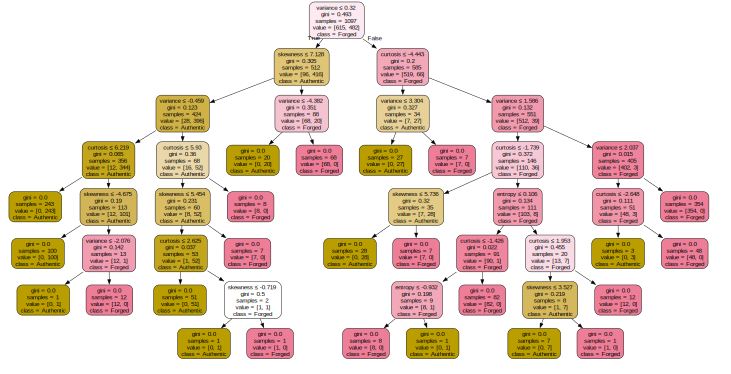

In [12]:
# graph.render("color_tree", format="png", cleanup=True)
graph = Source.from_file("color_tree.dot")
graph

**5.2 Compare performance of all models across the same performance metrics**  

This table both models performed nearly perfectly, with the Decision Tree slightly lower on the test set — a small hint of overfitting compared to the Logistic Regression.

| Model               | Dataset | Accuracy | Precision | Recall | F1-Score |
|---------------------|----------|-----------|-----------|--------|-----------|
| Logistic Regression | Test     | 1.00      | 1.00      | 1.00   | 1.00      |
| Decision Tree       | Train    | 1.00      | 1.00      | 1.00   | 1.00      |
| Decision Tree       | Test     | 0.99      | 0.99      | 0.99   | 0.99      |


**Reflection 5:** 

Both models performed exceptionally well, but the Logistic Regression model slightly outperformed the Decision Tree on the test set, maintaining perfect accuracy without signs of overfitting. The Decision Tree reached the same accuracy on the training data but dropped slightly on the test data, suggesting it fit more closely to the training patterns. Logistic Regression likely performed better because the dataset is small, clean, and linearly separable—conditions where simpler, linear models tend to generalize best.

## **Section 6. Final Thoughts & Insights**

**6.1 Summarize findings.**  

Both models performed exceptionally well in classifying genuine versus forged banknotes using just four statistical features derived from wavelet-transformed images. The Logistic Regression model achieved perfect accuracy on the test set, while the Decision Tree showed a very slight drop, suggesting minimal overfitting. Overall, the features captured clear, separable patterns between the two classes, allowing even simple models to perform at a near-perfect level. These results highlight how effective well-engineered statistical features can be for image-based classification tasks.

**6.2 Discuss challenges faced.**

The main challenges were understanding how the dataset was constructed and what each feature represented. Interpreting concepts like wavelet transforms, coefficients, and how statistical measures (variance, skewness, kurtosis, entropy) were derived from images required some conceptual digging. Beyond that, the data itself was already clean and well-structured, so the technical implementation was straightforward. The challenge was more about developing a clear understanding of the logic behind the features rather than the coding itself.

**6.3 If you had more time, what would you try next?**

If I had more time, I would experiment with additional models such as Random Forest or Support Vector Machine to see if ensemble or kernel-based methods offer any improvement or deeper insight. I’d also explore visualizing the decision boundaries between classes and perform feature scaling to confirm whether it impacts performance. Finally, I’d be interested in revisiting the original image data to see how different feature extraction methods might compare to the statistical approach used here.

**Reflection 6: What did you learn from this project?**

I learned how statistical features can effectively represent complex image data and how those features can be used in simple yet powerful classification models. I also gained a clearer understanding of key evaluation metrics—-accuracy, precision, recall, and F1-score—and how they connect to the confusion matrix. Most importantly, I saw how model choice depends on data characteristics: simpler models like Logistic Regression can outperform more complex ones when the data is clean, structured, and clearly separable.